# requirements
```
osmium version 1.13.2
libosmium version 2.17.1
Supported PBF compression types: none zlib
```

In [1]:
# In this paper, we use New York pbf data ver.2022-02-24T21:21:27Z.
# !wget https://download.geofabrik.de/north-america/us/new-york-latest.osm.pbf -O ../data/new-york-latest.osm.pbf
# !osmium extract --overwrite --bbox -74.02,40.70,-73.9,40.84 -o ../data/newyork.osm.pbf ../data/new-york-latest.osm.pbf

In [4]:
from datetime import datetime, timedelta
import os
from pathlib import Path
pwd = Path(os.getcwd())

import pytz
import random
import sys
sys.path.append(str(pwd.parent))
sys.path.append(str(pwd.parent / "config"))

import warnings
warnings.simplefilter("ignore")

import networkx as nx
import numpy as np
from osmread import parse_file, Node, Way
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm

from config import Config
from util import haversine

config = Config.load()

In [3]:
!pip install PyYAML

  Using cached PyYAML-6.0-cp39-cp39-macosx_11_0_arm64.whl (173 kB)


# Create whole node dataframe.

In [5]:
file_path = "../data/newyork.osm.pbf"
file = parse_file(file_path)

nodes = []
ways = []
for data in tqdm(file):
    if isinstance(data, Node):
        if data.tags == {}:
            nodes.append(data)
    if isinstance(data, Way):
        if data.nodes[0] != data.nodes[-1]:
            ways.append(data)

node_df = pd.DataFrame(columns=["NodeID", "WayID"])
for way in tqdm(ways):
    tmp_df = pd.DataFrame({"NodeID": way.nodes, "WayID": way.id})
    node_df = pd.concat([node_df, tmp_df])

1257936it [00:20, 61077.58it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47975/47975 [01:04<00:00, 740.57it/s]


# Trim node dataframe with LOCAL_REGION_BOUND.

In [6]:
node_map_lat = {}
node_map_lon = {}
for node in nodes:
    node_map_lat.update({node.id: node.lat})
    node_map_lon.update({node.id: node.lon})
node_df["Longitude"] = node_df["NodeID"].map(node_map_lon)
node_df["Latitude"] = node_df["NodeID"].map(node_map_lat)

node_df = node_df[
    (node_df["Longitude"] > config.LOCAL_REGION_BOUND.west_bound)
    & (node_df["Longitude"] < config.LOCAL_REGION_BOUND.east_bound)
    & (node_df["Latitude"] > config.LOCAL_REGION_BOUND.south_bound)
    & (node_df["Latitude"] < config.LOCAL_REGION_BOUND.north_bound)
]

# create node connection information

In [7]:
connected_node_df = pd.DataFrame(columns=["NodeID", "NextNodeID", "WayID", "Longitude", "Latitude"])
connected_node_df_list = []
for way_id in tqdm(node_df["WayID"].drop_duplicates()):
    tmp_df = node_df[node_df["WayID"]==way_id]
    if len(tmp_df) > 1:
        next_node_list = tmp_df["NodeID"].values.tolist()[1:] + [-1]
    else:
        next_node_list = [-1]

    assert len(tmp_df) == len(next_node_list)
    tmp_df["NextNodeID"] = next_node_list
    tmp_df["NextNodeID"] = tmp_df["NextNodeID"].astype(int)
    connected_node_df_list.append(tmp_df)
connected_node_df = pd.concat(connected_node_df_list)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6481/6481 [00:36<00:00, 179.71it/s]


# extract biggest graph.

In [8]:
graph = nx.Graph()
graph.add_nodes_from(connected_node_df["NodeID"].drop_duplicates().values)

for from_node, to_node in zip(connected_node_df["NodeID"].values, connected_node_df["NextNodeID"].values):
    if to_node == -1:
        continue
    else:
        graph.add_edge(from_node, to_node)

max_nodes = max(nx.connected_components(graph), key=len)

In [9]:
filtered_node_df = pd.DataFrame(columns=["NodeID", "NextNodeID", "WayID"])

for way_id in tqdm(connected_node_df["WayID"].drop_duplicates()):
    node_list = connected_node_df[connected_node_df["WayID"]==way_id]["NodeID"].values
    filtered_node_list = []
    for node_id in node_list:
        if node_id in max_nodes:
            filtered_node_list.append(node_id)
    if len(filtered_node_list) <= 1:
        continue
    next_node_list = filtered_node_list[1:] + [-1]
    assert len(filtered_node_list) == len(next_node_list)

    tmp_df = pd.DataFrame({"NodeID": filtered_node_list, "NextNodeID": next_node_list, "WayID": way_id})
    tmp_df["NextNodeID"] = tmp_df["NextNodeID"].astype(int)
    filtered_node_df = pd.concat([filtered_node_df, tmp_df])

filtered_node_df["Longitude"] = filtered_node_df["NodeID"].map(node_map_lon)
filtered_node_df["Latitude"] = filtered_node_df["NodeID"].map(node_map_lat)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6481/6481 [00:06<00:00, 961.10it/s]


In [10]:
node_info_df = filtered_node_df[["NodeID", "Longitude", "Latitude"]].drop_duplicates()

node_info = {
    node_id: {
        "node_index": node_index,
        "longitude": longitude,
        "latitude": lattitude,
    } for node_index, (node_id, longitude, lattitude) in enumerate(
        zip(node_info_df["NodeID"].values, node_info_df["Longitude"].values, node_info_df["Latitude"].values))
}

# check map.

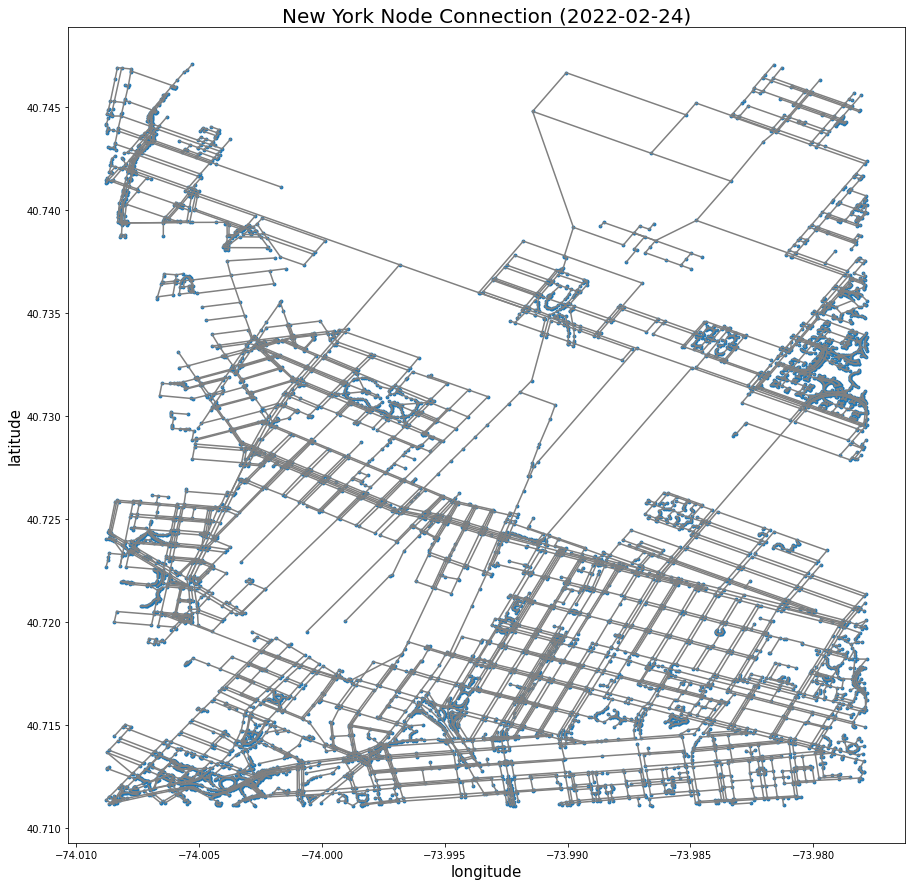

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=[15,15])
plt.scatter(node_info_df["Longitude"], node_info_df["Latitude"], s=8)

for from_node_id, to_node_id in zip(filtered_node_df["NodeID"].values, filtered_node_df["NextNodeID"].values):
    if to_node_id == -1:
        continue
    from_lng = node_info[from_node_id]["longitude"]
    from_lat = node_info[from_node_id]["latitude"]
    to_lng = node_info[to_node_id]["longitude"]
    to_lat = node_info[to_node_id]["latitude"]
    plt.plot([from_lng, to_lng], [from_lat, to_lat], color="gray")
plt.title("New York Node Connection (2022-02-24)", fontsize=20)
plt.xlabel("longitude", fontsize=15)
plt.ylabel("latitude", fontsize=15)
plt.savefig(f"../data/{config.DATA_SIZE}/map_{config.LOCAL_REGION_BOUND}.png")

# create cost csv.

In [12]:
num_nodes = len(node_info_df)
adj_matrix = np.ones([num_nodes, num_nodes]) / np.zeros([num_nodes, num_nodes])
for i in range(num_nodes):
    adj_matrix[i][i] = 0

for from_node_id, to_node_id in zip(filtered_node_df["NodeID"].values, filtered_node_df["NextNodeID"].values):
    if to_node_id == -1:
        continue
    from_node_idx = node_info[from_node_id]["node_index"]
    to_node_idx = node_info[to_node_id]["node_index"]

    cost = haversine(
        node_info[from_node_id]["longitude"],
        node_info[from_node_id]["latitude"],
        node_info[to_node_id]["longitude"],
        node_info[to_node_id]["latitude"],
    ) / 15 * 60 # Minutes to arrival. Cars drives at 15 kilometers per hour.

    adj_matrix[from_node_idx][to_node_idx] = cost
    adj_matrix[to_node_idx][from_node_idx] = cost

In [13]:
for k in tqdm(range(num_nodes)):
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adj_matrix[i][k]!=np.inf and adj_matrix[k][j]!=np.inf:
                adj_matrix[i][j] = min(adj_matrix[i][j], adj_matrix[i][k] + adj_matrix[k][j])
adj_matrix_df = pd.DataFrame(adj_matrix)
adj_matrix_df.to_csv(f"../data/{config.DATA_SIZE}/AccurateMap.csv", index=False, header=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8680/8680 [64:18:24<00:00, 26.67s/it]


# create node connection csv.

In [14]:
filtered_node_df["NextNodeLongitude"] = filtered_node_df["NextNodeID"].apply(lambda x: node_info[x]["longitude"] if x != -1 else -9999)
filtered_node_df["NextNodeLatitude"] = filtered_node_df["NextNodeID"].apply(lambda x: node_info[x]["latitude"] if x != -1 else -9999)
filtered_node_df.to_csv(f"../data/{config.DATA_SIZE}/NodeConnection.csv", index=False)

# create node csv.

In [15]:
node_data_df = filtered_node_df.reset_index(drop=True)[["NodeID", "Longitude", "Latitude"]]
node_data_df.drop_duplicates(inplace=True)
node_data_df[["RoadName", "Gid", "Distance", "WayID"]] = np.nan
node_data_df["NodeIndex"] = node_data_df["NodeID"].apply(lambda x: node_info[x]["node_index"])
node_data_df[["NodeIndex", "NodeID", "WayID", "Longitude", "Latitude", "RoadName", "Gid", "Distance"]].to_csv("../data/Node.csv", index=False)

# create driver.

In [16]:
driver_start_points = random.choices(node_data_df["NodeID"].values, k=15000)
df = pd.DataFrame({"DriverID": range(0,15000), "NodeS": driver_start_points})
df.to_csv(f"../data/{config.DATA_SIZE}/Drivers0601.csv", index=False)

# create order.

In [19]:
order_df = pd.read_csv(f"../data/yellow_tripdata_2016-06.csv")

USE_COLUMNS = [
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
]
RENAME_DICT = {
    "tpep_pickup_datetime": "Start_time",
    "tpep_dropoff_datetime": "End_time",
    "pickup_longitude": "PointS_Longitude",
    "pickup_latitude": "PointS_Latitude",
    "dropoff_longitude": "PointE_Longitude",
    "dropoff_latitude": "PointE_Latitude",
}

rename_order_df = order_df[USE_COLUMNS].rename(columns=RENAME_DICT).sort_values("Start_time").reset_index(drop=True)

# NewYorkエリア外のレコードを除去する.
rename_order_without_outlier_df = rename_order_df[
    (rename_order_df["PointS_Longitude"] > config.LOCAL_REGION_BOUND.west_bound)
    & (rename_order_df["PointS_Longitude"] < config.LOCAL_REGION_BOUND.east_bound)
    & (rename_order_df["PointE_Longitude"] > config.LOCAL_REGION_BOUND.west_bound)
    & (rename_order_df["PointE_Longitude"] < config.LOCAL_REGION_BOUND.east_bound)
    & (rename_order_df["PointS_Latitude"] > config.LOCAL_REGION_BOUND.south_bound)
    & (rename_order_df["PointS_Latitude"] < config.LOCAL_REGION_BOUND.north_bound)
    & (rename_order_df["PointE_Latitude"] > config.LOCAL_REGION_BOUND.south_bound)
    & (rename_order_df["PointE_Latitude"] < config.LOCAL_REGION_BOUND.north_bound)
]

In [20]:
nn = NearestNeighbors(algorithm='ball_tree')
nn.fit(node_data_df[["Longitude", "Latitude"]].values)

node_id_list = node_data_df["NodeID"].values.tolist()

_, start_indices = nn.kneighbors(
    rename_order_without_outlier_df[["PointS_Longitude", "PointS_Latitude"]], n_neighbors=1)
rename_order_without_outlier_df["NodeS"] = [node_id_list[i[0]] for i in start_indices]

_, end_indices = nn.kneighbors(
    rename_order_without_outlier_df[["PointE_Longitude", "PointE_Latitude"]], n_neighbors=1
)
rename_order_without_outlier_df["NodeE"] = [node_id_list[i[0]] for i in end_indices]

In [22]:
def newyork_datetime_to_utc(datetime_str: str) -> int:
    eastern = pytz.timezone('US/Eastern')
    date = datetime.strptime(datetime_str, "%Y-%m-%d %H:%M:%S")
    date.astimezone(eastern)
    return int(date.timestamp())

rename_order_without_outlier_df["Start_datetime"] = rename_order_without_outlier_df["Start_time"].apply(
    lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
)
rename_order_without_outlier_df["ID"] = range(len(rename_order_without_outlier_df))
start_date = datetime(year=2016, month=6, day=1)
directory = "train"
while True:
    next_date = start_date + timedelta(days=1)
    tmp_df = rename_order_without_outlier_df[
        (rename_order_without_outlier_df["Start_datetime"]<next_date)
        & (rename_order_without_outlier_df["Start_datetime"]>start_date)
    ]
    tmp_df["Start_time"] = tmp_df["Start_time"].apply(newyork_datetime_to_utc)
    tmp_df["End_time"] = tmp_df["End_time"].apply(newyork_datetime_to_utc)
    if start_date.day >= 24:
        directory = "test"
    tmp_df[["ID"] + list(RENAME_DICT.values()) + ["NodeS", "NodeE"]].to_csv(
        f"../data/{config.DATA_SIZE}/Order/modified/{directory}/order_2016{str(start_date.month).zfill(2)}{str(start_date.day).zfill(2)}.csv",
        index=False
    )
    start_date = next_date
    if start_date.month != 6:
        break